### 测试集数据预处理

#### trec07p

In [1]:
import os
import re
from collections import Counter
from email import parser, policy
from html import unescape

import nltk
import pandas
import urlextract
from nltk.corpus import stopwords
from sklearn import metrics, preprocessing, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from email.parser import BytesParser

import joblib
# import sys
# print(sys.executable)

In [9]:
# 读取数据集
INDEX_PATH = os.path.join('trec07p', 'full', 'index')  # 先使用较小的数据集进行训练
DATA_PATH = os.path.join('trec07p', 'data')  # 数据文件夹路径
labels = []
filenames = []

In [10]:
# 将delay中的标签和对应的文件名保存
def create_dataset(index_path):
    with open(index_path) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.split(' ')
            labels.append(line[0])
            filenames.append(line[1].strip('\n').split('/')[-1])
            
create_dataset(INDEX_PATH)

In [11]:
print(filenames[1])

inmail.2


In [ ]:
# 下载delay中索引的文件内容
def load_email(filename, file_path):
    with open(os.path.join(file_path, filename), 'rb') as f:
        return parser.BytesParser(policy=policy.default).parse(f)

raw_emails = [load_email(name, DATA_PATH) for name in filenames]

In [5]:
print(raw_emails[3].get_content().strip())  # 打印邮件文本内容，注意这里输出内容不一定是正确的，只有当邮件为文本类型，才能输出；不能正确输出说明邮件是多部份的

Hey Billy, 

it was really fun going out the other night 
and talking, while we were out you said that you felt
insecure about your manhood, I noticed in the toilets
you were quite small in that area : ) , but not to 
worry.. that website that I was telling you about is 
my secret weapon to an extra 3 inches, trust me.. girls
love bigger ones, I've had 5 times as many chicks 
since I used these pills a year ago. The package I used
was the 6 month supply one,  and its worth every 
cent and more.. the website is http://ctmay.com 
Ring me on the weekend and we will go out and drink 
again and let you know some more secrets : ).
Later dude, Brad


In [6]:
# 数据预处理
# 构造函数获取邮件的结构类型及其计数

# 确定每封电子邮件的结构类型
def get_email_structure(email):
    if isinstance(email, str): # 字符串直接返回
        return email
    payload = email.get_payload() # 提取email的主体部分
    if isinstance(payload, list): # 如果是列表，说明该邮件为多部份
        return 'multipart({})'.format(', '.join([get_email_structure(sub_email) for sub_email in payload]))
        # 如果有两个子部分，一个是 text/plain，另一个是 text/html，那么最终的结果将是 'multipart(text/plain, text/html)'
    else: # 否则一般是text/plain或text/html
        return email.get_content_type()

In [7]:
# 统计一组电子邮件中各种结构类型的出现次数
def structures_counter(emails):
    structures = Counter() # 字典类型
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [8]:
print(structures_counter(raw_emails).most_common())  # 显示邮件包含的类型
"""
这对于分析电子邮件数据集的结构分布非常有用，可以帮助我们理解数据集中最常见的电子邮件类型，从而为进一步的数据处理和特征工程提供信息。
例如，如果多数邮件都是纯文本类型，那么我们可能会专注于文本内容的分析；如果有大量的多部分邮件，我们可能需要考虑如何处理嵌入的图片或附件。
"""

[('text/plain', 29989), ('multipart(text/plain, text/html)', 17496), ('text/html', 11978), ('multipart(multipart(text/plain, text/html), image/gif)', 5066), ('multipart(text/html)', 3741), ('multipart(multipart(text/plain, text/html), image/jpeg)', 2510), ('multipart(text/html, image/gif)', 1021), ('multipart(text/plain)', 682), ('multipart(text/plain, application/pgp-signature)', 595), ('multipart(text/plain, text/plain)', 398), ('multipart(multipart(text/plain, text/html), image/png)', 240), ('multipart(multipart(text/plain, text/html))', 151), ('multipart(multipart(text/plain, text/html), text/plain)', 135), ('multipart(text/html, text/plain, image/png)', 122), ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/jpeg, application/octet-stream)', 116), ('multipart(text/plain charset=us-ascii, text/html)', 108), ('multipart(text/plain, application/octet-stream)', 75), ('multipart(multipart(text/plain, text/html), image/gif, image/gif, image/gif, image/gif, applic

'\n这对于分析电子邮件数据集的结构分布非常有用，可以帮助我们理解数据集中最常见的电子邮件类型，从而为进一步的数据处理和特征工程提供信息。\n例如，如果多数邮件都是纯文本类型，那么我们可能会专注于文本内容的分析；如果有大量的多部分邮件，我们可能需要考虑如何处理嵌入的图片或附件。\n'

In [9]:
# 将原始的电子邮件内容转换为更适合文本分析和机器学习模型训练的格式

# 将HTML内容转换为纯文本，同时替换为相应的关键词
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub(r'<[aA]\s.*?>', 'HYPERLINK', text, flags=re.M | re.S | re.I)
    text = re.sub(r'<img\s.*?>', 'IMAGE', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [10]:
# 用于从电子邮件中提取文本内容
def email_to_text(email):
    html = None
    # walk()打印出一封具有多部分结构之信息的每个部分的MIME类型
    for part in email.walk():
        ctype = part.get_content_type()
        if ctype not in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except LookupError:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [11]:
# 下载 stopwords 资源
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86180\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# 分词
stopwords_list = stopwords.words('english')  # 英文停用词列表
token = nltk.stem.SnowballStemmer('english')  # 提取词干，词干提取器对象，用于将单词还原为基本形式或词干。例如，将“running”还原为“run”。

# 将所有小写英文字母添加到停用词列表
for single in range(97, 123):
    stopwords_list.append(chr(single))
    
extractor = urlextract.URLExtract() # 创建了一个URL提取器对象，用于从文本中找出URL

In [13]:
# 将电子邮件文本转换为一个清洗和标准化的单词列表
def word_split(email):
    text = email_to_text(email) or ' '
    text = text.lower()
    text = re.sub(r'\W+', ' ', text, flags=re.M) # 使用正则表达式替换文本中的所有非字母数字字符为单个空格
    urls = list(set(extractor.find_urls(text))) # 一个去重的URL列表
    urls.sort(key=lambda item: len(item), reverse=True) # 将找到的URL按长度降序排序
    for url in urls:
        text = text.replace(url, "URL") # 将文本中的所有URL替换为特征词“URL”
    text = re.sub(r'\d+(?:\.\d*[eE]\d+)?', 'NUMBER', text) # 使用正则表达式将文本中的所有数字替换为字符串“NUMBER”
    content = list(nltk.word_tokenize(text)) # 使用NLTK的 word_tokenize 函数将文本分割成单词列表
    all_words = []
    for word in content:
        if word not in stopwords_list:
            word = token.stem(word)
            all_words.append(word)
    return all_words

In [14]:
# 下载 punkt 资源
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86180\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
all_emails = [word_split(data) for data in raw_emails]

In [16]:
print(all_emails[1])  # 查看分词结果

['hi', 'updat', 'gulus', 'check', 'mirror', 'seem', 'littl', 'typo', 'debian', 'readm', 'file', 'exampl', 'http', 'gulus', 'usherbrook', 'ca', 'debian', 'readm', 'ftp', 'ftp', 'fr', 'debian', 'org', 'debian', 'readm', 'test', 'lenni', 'access', 'releas', 'dist', 'test', 'current', 'test', 'develop', 'snapshot', 'name', 'etch', 'packag', 'test', 'unstabl', 'pass', 'autom', 'test', 'propog', 'releas', 'etch', 'replac', 'lenni', 'like', 'readm', 'html', 'yan', 'morin', 'consult', 'en', 'logiciel', 'libr', 'yan', 'morin', 'savoirfairelinux', 'com', 'number', 'number', 'number', 'unsubscrib', 'email', 'debian', 'mirror', 'request', 'list', 'debian', 'org', 'subject', 'unsubscrib', 'troubl', 'contact', 'listmast', 'list', 'debian', 'org']


#### 保存处理数据

In [17]:
# 保存处理结果，方便后面直接使用
import json
# 将预处理后的邮件数据保存到JSON文件
with open('preprocessed_trec07p_emails.json', 'w', encoding='utf-8') as jsonfile:
    json.dump(all_emails, jsonfile, ensure_ascii=False, indent=4)

#### trec06p

In [2]:
import os
from email import policy
from email.parser import BytesParser
# 定义数据集的路径
INDEX_PATH = os.path.join('t6_test25', 'full', 'index')
DATA_PATH = os.path.join('t6_test25', 'data')
labels = []
filepaths = []

In [3]:
# 从index文件创建数据集索引
def create_dataset(index_path):
    with open(index_path) as f:
        for line in f:
            label, relative_path = line.strip().split(' ')
            labels.append(label)
            # 获取邮件文件的完整路径
            filepaths.append(os.path.join(DATA_PATH, *relative_path.split('/')[2:]))

create_dataset(INDEX_PATH)

In [4]:
# 读取邮件内容
def load_email(filepath):
    with open(filepath, 'rb') as f:
        return BytesParser(policy=policy.default).parse(f)

# 遍历文件路径列表，加载每封邮件
raw_emails = [load_email(filepath) for filepath in filepaths]

In [5]:
print(raw_emails[3].get_content().strip())  # 打印邮件文本内容，注意这里输出内容不一定是正确的，只有当邮件为文本类型，才能输出；不能正确输出说明邮件是多部份的

Greetings all.  This is to verify your subscription to the plan9-fans
list.   The charter members (those who signed up on the first day)
are (in order)

	"Scott Schwartz" <schwartz@cs.psu.edu>
	"Chuck Rendleman" <chuckr@bigbird.llnl.gov>
	"Michael John Haertel" <mike@cs.uoregon.edu>
	"Neil Weisenfeld" <weisen@alw.nih.gov>
	"Ozan S. Yigit" <oz@sis.yorku.ca>
	"Sanjeev Y. Dharap" <sanjeev@cs.psu.edu>
	Eric Krohn <krohn@bae.bellcore.com>
	"DaviD W. Sanderson" <dws@ssec.wisc.edu>
	"Dennis Colarelli" <djc@niwot.scd.ucar.EDU>
	Tony Sloane <tony@cs.colorado.edu>
	Bob Gibson <rjg@sco.COM>
	Chris Siebenmann <cks@hawkwind.utcs.toronto.edu>
	"Roger Peppe" <rog@ohm.york.ac.uk>
	"Chet Ramey" <chet@po.cwru.edu>
	"Tim Tsai" <m-it2691@cs.nyu.edu>
	Noel Hunt <noel@es.su.oz.au>

Due to rdist and local politics, it takes a day before changes to the
list take effect.


In [6]:
# 数据预处理
# 构造函数获取邮件的结构类型及其计数

# 确定每封电子邮件的结构类型
def get_email_structure(email):
    if isinstance(email, str): # 字符串直接返回
        return email
    payload = email.get_payload() # 提取email的主体部分
    if isinstance(payload, list): # 如果是列表，说明该邮件为多部份
        return 'multipart({})'.format(', '.join([get_email_structure(sub_email) for sub_email in payload]))
        # 如果有两个子部分，一个是 text/plain，另一个是 text/html，那么最终的结果将是 'multipart(text/plain, text/html)'
    else: # 否则一般是text/plain或text/html
        return email.get_content_type()

In [7]:
# 统计一组电子邮件中各种结构类型的出现次数
def structures_counter(emails):
    structures = Counter() # 字典类型
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [8]:
from collections import Counter
print(structures_counter(raw_emails).most_common())  # 显示邮件包含的类型
"""
这对于分析电子邮件数据集的结构分布非常有用，可以帮助我们理解数据集中最常见的电子邮件类型，从而为进一步的数据处理和特征工程提供信息。
例如，如果多数邮件都是纯文本类型，那么我们可能会专注于文本内容的分析；如果有大量的多部分邮件，我们可能需要考虑如何处理嵌入的图片或附件。
"""

[('text/plain', 35), ('multipart(text/plain, text/html)', 12), ('multipart(text/plain)', 2), ('multipart(multipart(text/plain, text/html), image/png)', 2), ('multipart/alternative', 1)]


'\n这对于分析电子邮件数据集的结构分布非常有用，可以帮助我们理解数据集中最常见的电子邮件类型，从而为进一步的数据处理和特征工程提供信息。\n例如，如果多数邮件都是纯文本类型，那么我们可能会专注于文本内容的分析；如果有大量的多部分邮件，我们可能需要考虑如何处理嵌入的图片或附件。\n'

In [9]:
# 将原始的电子邮件内容转换为更适合文本分析和机器学习模型训练的格式

# 将HTML内容转换为纯文本，同时替换为相应的关键词
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub(r'<[aA]\s.*?>', 'HYPERLINK', text, flags=re.M | re.S | re.I)
    text = re.sub(r'<img\s.*?>', 'IMAGE', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [10]:
# 用于从电子邮件中提取文本内容
def email_to_text(email):
    html = None
    # walk()打印出一封具有多部分结构之信息的每个部分的MIME类型
    for part in email.walk():
        ctype = part.get_content_type()
        if ctype not in ('text/plain', 'text/html'):
            continue
        try:
            content = part.get_content()
        except LookupError:
            content = str(part.get_payload())
        if ctype == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [11]:
# 下载 stopwords 资源
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\86180\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
import urlextract

# 分词
stopwords_list = stopwords.words('english')  # 英文停用词列表
token = nltk.stem.SnowballStemmer('english')  # 提取词干，词干提取器对象，用于将单词还原为基本形式或词干。例如，将“running”还原为“run”。

# 将所有小写英文字母添加到停用词列表
for single in range(97, 123):
    stopwords_list.append(chr(single))
    
extractor = urlextract.URLExtract() # 创建了一个URL提取器对象，用于从文本中找出URL

In [13]:
# 将电子邮件文本转换为一个清洗和标准化的单词列表
def word_split(email):
    text = email_to_text(email) or ' '
    text = text.lower()
    text = re.sub(r'\W+', ' ', text, flags=re.M) # 使用正则表达式替换文本中的所有非字母数字字符为单个空格
    urls = list(set(extractor.find_urls(text))) # 一个去重的URL列表
    urls.sort(key=lambda item: len(item), reverse=True) # 将找到的URL按长度降序排序
    for url in urls:
        text = text.replace(url, "URL") # 将文本中的所有URL替换为特征词“URL”
    text = re.sub(r'\d+(?:\.\d*[eE]\d+)?', 'NUMBER', text) # 使用正则表达式将文本中的所有数字替换为字符串“NUMBER”
    content = list(nltk.word_tokenize(text)) # 使用NLTK的 word_tokenize 函数将文本分割成单词列表
    all_words = []
    for word in content:
        if word not in stopwords_list:
            word = token.stem(word)
            all_words.append(word)
    return all_words

In [14]:
# 下载 punkt 资源
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\86180\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
import re
from html import unescape
all_emails = [word_split(data) for data in raw_emails]

In [16]:
print(all_emails[0])

['mail', 'list', 'queri', 'week', 'ago', 'run', 'also', 'set', 'archiv', 'server', 'see', 'follow', 'offici', 'welcom', 'list', 'messag', 'moment', 'joe', 'buehler', 'mail', 'list', 'peopl', 'desir', 'serious', 'orthodox', 'discuss', 'roman', 'cathol', 'religion', 'assum', 'cater', 'main', 'cathol', 'everyon', 'els', 'welcom', 'provid', 'oper', 'within', 'guidelin', 'interest', 'doctrin', 'bent', 'certain', 'go', 'limit', 'list', 'sort', 'discuss', 'particip', 'usenet', 'religion', 'group', 'number', 'year', 'one', 'primari', 'observ', 'cathol', 'net', 'know', 'religion', 'well', 'hope', 'list', 'might', 'help', 'remedi', 'problem', 'extent', 'would', 'like', 'make', 'net', 'resourc', 'avail', 'cathol', 'want', 'know', 'religion', 'far', 'moder', 'polici', 'goe', 'cathol', 'church', 'democraci', 'monarchi', 'subject', 'divin', 'given', 'constitut', 'set', 'rule', 'church', 'neither', 'parish', 'priest', 'bishop', 'pope', 'everyon', 'adher', 'way', 'christ', 'set', 'thing', 'think', 'fo

In [17]:
# 保存处理结果，方便后面直接使用
import json
# 将预处理后的邮件数据保存到JSON文件
with open('preprocessed_test25_emails.json', 'w', encoding='utf-8') as jsonfile:
    json.dump(all_emails, jsonfile, ensure_ascii=False, indent=4)

with open('preprocessed_test25_labels_emails.json', 'w', encoding='utf-8') as jsonfile:
    json.dump(labels, jsonfile, ensure_ascii=False, indent=4)

In [24]:
import json
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

with open('preprocessed_test25_emails.json', 'r', encoding='utf-8') as file:
    all_emails = json.load(file)

with open('preprocessed_test25_labels_emails.json', 'r', encoding='utf-8') as file:
    labels = json.load(file)

# 加载模型和向量化器
model = load('MulNB_model.pkl')
vectorizer = load('MulNB_vectorizer.pkl')

# 向量化邮件文本
X = vectorizer.transform(all_emails)

# 使用模型进行预测
y_pred = model.predict(X)

# 计算准确率
accuracy = accuracy_score(labels, y_pred)
print(f"Accuracy: {accuracy}")

# 打印分类报告
print(classification_report(labels, y_pred))

# 绘制混淆矩阵
conf_matrix = confusion_matrix(labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


C:\ANACONDA\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


Accuracy: 0.0


ValueError: Mix of label input types (string and number)

### 模型性能分析

#### 简单占比比对

In [19]:
import os
import joblib
# 加载模型和向量化器
model = joblib.load('MulNB_model.pkl')
vectorizer = joblib.load('MulNB_vectorizer.pkl')

##### 无预处理测试集

In [ ]:
# 遍历文件夹中的邮件
emails, predictions = [], []
for root, dirs, files in os.walk('trec07p/data'):
    for file in files:
        with open(os.path.join(root, file), 'r', encoding='utf-8', errors='ignore') as f:
            email_content = f.read()
        emails.append(email_content)

In [53]:
# 特征提取
email_features = vectorizer.transform(emails)
# 模型预测
predictions = model.predict(email_features)
# 计算垃圾邮件和非垃圾邮件的数量
spam_count = sum(predictions)
ham_count = len(predictions) - spam_count

# 计算占比
spam_ratio = spam_count / len(predictions)
ham_ratio = ham_count / len(predictions)

print(f'垃圾邮件占比: {spam_ratio:.2%}')
print(f'非垃圾邮件占比: {ham_ratio:.2%}')

垃圾邮件占比: 51.92%
非垃圾邮件占比: 48.08%


##### 预处理测试集

In [9]:
# 特征提取
# email_features = vectorizer.transform(emails)
# 将每个邮件词汇表转换为字符串
import json
with open('preprocessed/preprocessed_trec06p_emails.json', 'r', encoding = 'utf-8') as file:
    all_emails = json.load(file)
all_emails_str = [" ".join(email) for email in all_emails]

In [10]:
# 然后使用转换后的字符串列表进行特征提取
email_features = vectorizer.transform(all_emails_str)

# 模型预测
predictions = model.predict(email_features)
# 计算垃圾邮件和非垃圾邮件的数量
spam_count = sum(predictions)
ham_count = len(predictions) - spam_count

# 计算占比
spam_ratio = spam_count / len(predictions)
ham_ratio = ham_count / len(predictions)

print(f'垃圾邮件占比: {spam_ratio:.2%}')
print(f'非垃圾邮件占比: {ham_ratio:.2%}')

垃圾邮件占比: 52.46%
非垃圾邮件占比: 47.54%


##### 微调决策阈值

##### 真实占比

In [26]:
index_path = 'trec06p/full/index'
# 初始化计数器
spam_count = 0
ham_count = 0

with open(index_path, 'r') as file:
    for line in file:
        if 'spam' in line:
            spam_count += 1
        elif 'ham' in line:
            ham_count += 1

# 计算总邮件数量
total_emails = spam_count + ham_count

# 计算占比
spam_percentage = (spam_count / total_emails) * 100
ham_percentage = (ham_count / total_emails) * 100

# 输出结果
print(f"垃圾邮件占比: {spam_percentage:.2f}%")
print(f"非垃圾邮件占比: {ham_percentage:.2f}%")

FileNotFoundError: [Errno 2] No such file or directory: 'trec06p/full/index'

#### 错误案例分析

In [81]:
import json
import joblib

# 加载模型和向量化器
model = joblib.load('models/MulNB_model.pkl')
vectorizer = joblib.load('vectorizers/MulNB_vectorizer.pkl')  # 确保这里是向量化器的文件

# 读取测试集数据
with open('preprocessed_test25_emails.json', 'r', encoding='utf-8') as file:
    test_data = json.load(file)

# 读取索引文件
with open('test25/full/index', 'r', encoding='utf-8') as file:
    index_data = file.readlines()

# 预处理索引文件数据
index_data = [line.strip().split() for line in index_data]
labels = [1 if line[0] == 'spam' else 0 for line in index_data]  # spam为1，ham为0
file_paths = [line[1] for line in index_data]

# 将词汇列表转换为字符串
test_data_strings = [' '.join(email) for email in test_data]

# 使用向量化器转换测试数据
test_data_transformed = vectorizer.transform(test_data_strings)

# 使用模型进行预测
predictions = model.predict(test_data_transformed)

# 找出错误的案例
errors = []
for i, (prediction, label) in enumerate(zip(predictions, labels)):
    if prediction != label:
        errors.append((file_paths[i], 'spam' if prediction else 'ham', 'spam' if label else 'ham'))

# 打印错误案例的数量和一些示例
print(f"Total number of errors: {len(errors)}")
for error in errors[:10]:  # 打印前10个错误案例
    print(f"File: {error[0]}, Predicted: {error[1]}, Actual: {error[2]}")

Total number of errors: 5
File: ../data/000/005, Predicted: spam, Actual: ham
File: ../data/000/023, Predicted: spam, Actual: ham
File: ../data/111/004, Predicted: ham, Actual: spam
File: ../data/111/006, Predicted: ham, Actual: spam
File: ../data/111/018, Predicted: ham, Actual: spam


In [69]:
# 将词汇列表转换为字符串
test_data_strings = [' '.join(test_data[45])]

# 使用向量化器转换测试数据
test_data_transformed = vectorizer.transform(test_data_strings)

# 使用模型进行预测
predictions = model.predict(test_data_transformed)
print(predictions)

[1]


#### 比较不同模型性能

#### 计算ROC-AUC面积

In [87]:
import joblib
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import json
# 加载模型和向量化器
loaded_model = joblib.load('models/BernliNB_model.pkl')
loaded_tfidf_vectorizer = joblib.load('vectorizers/BernliNB_vectorizer.pkl')

In [88]:
# 加载预处理后的邮件数据和标签
with open('preprocessed_test25_emails.json', 'r', encoding='utf-8') as file:
    preprocessed_trec07p_emails = json.load(file)
# 读取测试集索引文件，获取真实标签
labels = []
with open('test25/full/index', 'r', encoding='utf-8') as file:
    for line in file:
        label, _ = line.strip().split()
        labels.append(1 if label == 'spam' else 0)

In [89]:
# 使用向量化器转换邮件数据
X_test = loaded_tfidf_vectorizer.transform([' '.join(email) for email in preprocessed_trec07p_emails])
# 使用模型进行预测
y_scores = loaded_model.predict_proba(X_test)[:, 1]
# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(labels, y_scores)
roc_auc = auc(fpr, tpr)

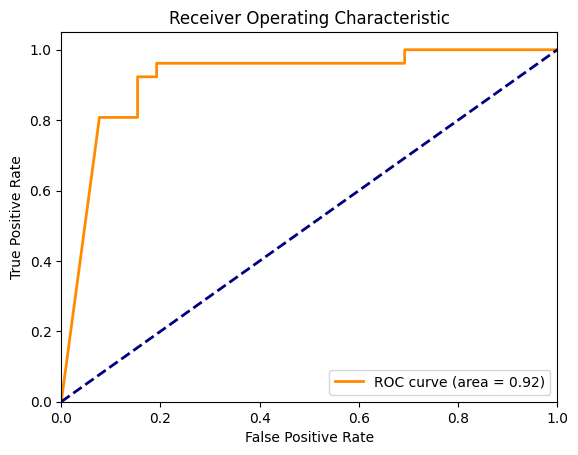

In [90]:
# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [65]:
print('AUC面积: %0.2f' % roc_auc)

AUC面积: 0.97
